## Setup model
#### Initialize electrode locations

In [1]:
import numpy as np
import pandas as pd
import os, shutil

# define initial electrode position lying along y axis centered at the origin
nsites = 9
probe_len = 1000 # um
pos = np.zeros((nsites,3))
pos[:,1] = np.linspace(-probe_len/2,probe_len/2,nsites)

# save electrode position to file
elec_file = 'linear_electrode.csv'
df = {'channel':np.arange(pos.shape[0])}
df.update({x+'_pos':pos[:,i] for i,x in enumerate(list('xyz'))})
df = pd.DataFrame(df)
df.to_csv(elec_file,sep=' ',index=False)

# copy file
filelocation = 'sim_details/components/recXelectrodes'
elec_destpath = os.path.join(os.getcwd(),filelocation,elec_file)
shutil.copy(elec_file,elec_destpath)

'D:\\BMTKtemp\\stylized single cell\\sim_details/components/recXelectrodes\\linear_electrode.csv'

In [1]:
import os, shutil

dest='/sim_details/components/morphologies'
source = 'stylized.swc'
fulldest=os.path.join(os.getcwd()+dest)
shutil.copy(source,fulldest)

'D:\\BMTKtemp\\stylized single cell/sim_details/components/morphologies\\stylized.swc'

#### Build bmtk network

In [2]:
from bmtk.builder.networks import NetworkBuilder
import numpy as np

net = NetworkBuilder('mcortex')
net.add_nodes(cell_name='stylized',
              positions = np.zeros((1,3)),
              potental='exc',
              model_type='biophysical',
              model_template='ctdb:Biophys1.hoc',
              model_processing='aibs_perisomatic',
              dynamics_params='fit_488695444_f9.json', #from allen database
              morphology= 'stylized.swc')

In [3]:
%%bash
rm network/*

In [4]:
net.build()
net.save_nodes(output_dir='network')

In [5]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='sim_details',      # Where to save the scripts and config files 
                 network_dir='network',    # Location of directory containing network files
                 tstop=40.0, dt=0.025,     # Run a simulation for 2000 ms at 0.025 ms intervals
                 report_vars=['v','i_membrane_','ecp'], # Tells simulator we want to record membrane potential and calcium traces
                 current_clamp={
                     'amp': 12.9,
                     'delay': 19.75,
                     'duration': 0.1
                 },
                 include_examples=True,    # Copies components files
                 compile_mechanisms=False   # Will try to compile NEURON mechanisms
                )

In [6]:
# use a custom simulation_config file
import os, shutil

dest='/sim_details/simulation_config.json'
source = 'simulation_config.json'
fulldest=os.path.join(os.getcwd()+dest)
shutil.copy(source,fulldest)

'D:\\BMTKtemp\\stylized single cell/sim_details/simulation_config.json'

### Simulation

In [7]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('sim_details/simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2020-08-10 23:27:38,759 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2020-08-10 23:27:39,179 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2020-08-10 23:27:39,497 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2020-08-10 23:27:39,615 [INFO] Running simulation for 40.000 ms with the time step 0.025 ms


INFO:NEURONIOUtils:Running simulation for 40.000 ms with the time step 0.025 ms


2020-08-10 23:27:39,622 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2020-08-10 23:27:39,628 [INFO] Block save every 1600 steps


INFO:NEURONIOUtils:Block save every 1600 steps


2020-08-10 23:27:40,001 [INFO]     step:1600 t_sim:40.00 ms


INFO:NEURONIOUtils:    step:1600 t_sim:40.00 ms


2020-08-10 23:27:40,067 [INFO] Simulation completed in 0.4519 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.4519 seconds 


#### Calculate LFP
Define the function for calculating the LFP (convert this into delfi simulator)

In [8]:
from copy import deepcopy
import numpy as np
from bmtk.simulator.core.simulator import Simulator
from bmtk.simulator.bionet.modules.ecp import EcpMod

def calc_lfp(sim,Imem,Elec_pos,gid=0,sigma=0.3):
    assert isinstance(sim,Simulator), "first input should be an instance of class Simulator."
    try:
        ecp_ind = [isinstance(mod,EcpMod) for mod in sim._sim_mods].index(True)
    except ValueError:
        raise LookupError("no ecp module found.")
    rel = deepcopy(sim._sim_mods[ecp_ind]._rel)
    if gid not in rel.transfer_resistances.keys(): raise LookupError("cell gid not found.")
    
    Imem = np.asarray(Imem)
    Elec_pos = np.asarray(Elec_pos)
    assert Imem.shape[1]==rel.transfer_resistances[gid].shape[1],\
    "Imem 2nd dimemsion must have the same length as the number of segments in the selected cell."
    assert Elec_pos.ndim==2 and Elec_pos.shape[1]==3, "Elec_pos must be an n-by-3 2-D array."
    if type(sigma) is not float: raise TypeError("sigma must be float.")
    
    cell = sim.net.get_cell_gid(gid)
    rel.pos = Elec_pos.transpose()
    rel.nsites = Elec_pos.shape[0]
    rel.calc_transfer_resistance(gid,cell.get_seg_coords(),cell.morphology.seg_coords)
    if sigma!=0.3: rel.transfer_resistances[gid] = 0.3/sigma*transfer_resistances[gid]
    return np.dot(Imem,rel.transfer_resistances[gid].transpose())

Load transmembrane recordings and initial electrodes location

In [9]:
import h5py
import numpy as np
import pandas as pd
import os

# Get transmembrane currents in "Im"
outpath = 'sim_details/output/'
filename = 'imem.h5'
im_file = outpath + filename
im_f = h5py.File(im_file,'r')
Im = im_f['report/mcortex/data'][()]
t = np.arange(*im_f['report/mcortex/mapping/time']) # array of time

# Get initial position of electrodes in "pos"
elec_file = 'linear_electrode.csv'
filelocation = 'sim_details/components/recXelectrodes'
elec_destpath = os.path.join(os.getcwd(),filelocation,elec_file)
pos = pd.read_csv(elec_destpath,sep=' ')[[x+'_pos' for x in list('xyz')]].values

#### Random relocate electrodes
Function to calculate coordinates of an object in new position after rotation and translation.  
First rotate angle alpha about y-axis (spin), then rotate the unit vector of y-axis toward x-axis to height h (elevation), then rotate angle phi about y axis (azimuth).  
Finally translate the object by translate(x,y,z).  
If new_coordinate is True, use coordinate system with respect to the object at the new position.

In [10]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def newposition(translate,rotate,old_position=[0.,0.,0.],new_coordinate=True):
    translate = np.asarray(translate)
    old_position = np.asarray(old_position)
    Rot = R.from_euler('yzy',[rotate[0],-np.arccos(rotate[1]),rotate[2]]) # angles: alpha, theta=arcsin(h), phi
    if new_coordinate:
        new_position = Rot.inv().apply(old_position-translate)
    else:
        new_position = Rot.apply(old_position)+translate
    return new_position

# the range of 4 parameters (uniform prior) of cell position
# center coordinates (x,y), orientation unit vector (elevation height y, azimuth angle phi in xz-plane) all uniformly distributed
prior_min = np.array([-1000,-1000,-1,-np.pi])
prior_max = np.array([1000,1000,1,np.pi])

Example of LFP from new electrode position

In [11]:
# generate one example of 4 parameters for relocating the cell
params = np.array([np.random.uniform(prior_min[i],prior_max[i]) for i in range(prior_min.size)])
translate = np.insert(params[:2],2,0.) # translate cell along x,y only
rotate = np.insert(params[2:],0,0.) # do not spin, only change orientation of the cell
print(translate)
print(rotate)

# new_coordinate=True. Using coordinate system of the cell to represent electrode position,
# Equivalent to relocating the cell with the electrodes unmoved
newpos = newposition(translate,rotate,pos) 
lfp_new = calc_lfp(sim,Im,newpos,gid=0)

[-576.67230308 -324.73960865    0.        ]
[ 0.         -0.48349254  1.61039776]


Plot example LFP recordings

<IPython.core.display.Javascript object>


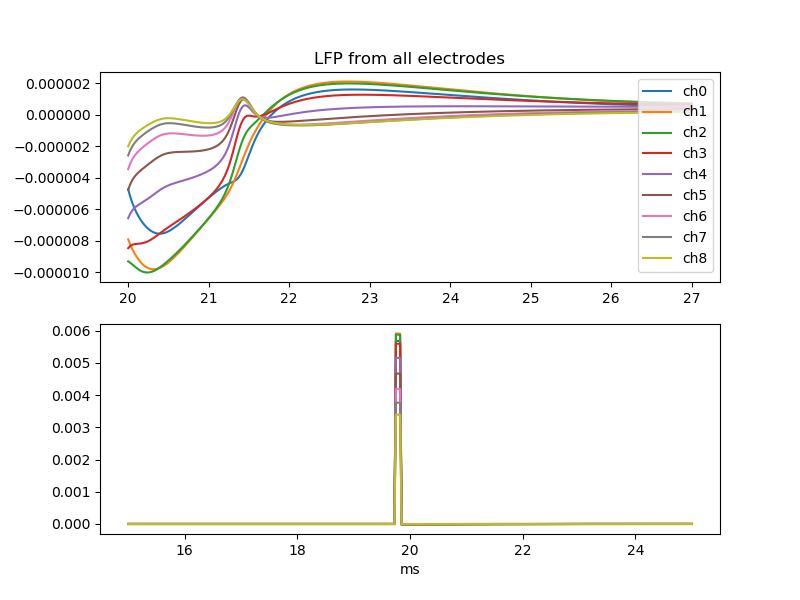

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

_,ax = plt.subplots(2,1,figsize=(8,6))
idx = (t>=20) & (t<=27)
ax[0].set_title('LFP from all electrodes')
for i in range(lfp_new.shape[1]):
    ax[0].plot(t[idx],lfp_new[idx,i], label='ch'+str(i))
ax[0].legend(loc=1)

idx = (t>=15) & (t<=25)
ax[1].set_xlabel('ms')
for i in range(lfp_new.shape[1]):
    ax[1].plot(t[idx],lfp_new[idx,i],color=ax[0].lines[i].get_color())

### Analyze results
#### Check morphology and electrodes location and view LFP
Function to plot morphology

In [14]:
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib notebook

def plot_morphology(network,gid=0,rotated=True,figsize=(8,6),ax=None):
    cell = network.get_cell_gid(gid)
    morph = cell.morphology
    if rotated:
        coords = cell.get_seg_coords()
    else:
        coords = morph.seg_coords
    stype = morph.seg_prop['type'].astype(int)-1
    st = list(morph.sec_type_swc.keys())[::2]
    ilab = [list(stype).index(i) for i in range(len(st))]
    clr = ['g','r','b','c']
    if ax is None:
        print(cell.morphology_file)
        fig = plt.figure(figsize=figsize)
        ax = plt.axes(projection='3d')
    else:
        fig = ax.figure
        fig.set_size_inches(figsize)
    for i in range(stype.size):
        label = st[ilab.index(i)] if i in ilab else None
        if stype[i]==0:
            ax.scatter(*coords['p05'][:,i].tolist(),c=clr[0],s=30,label=label)
        else:
            ax.plot3D(*[[coords['p0'][j,i],coords['p1'][j,i]] for j in range(3)],
                      color=clr[stype[i]],label=label)
    ax.legend(loc=1)
    return fig, ax

Function to plot electrode location and LFP results

In [15]:
plt.ioff()
fig = plt.figure()
ax1 = fig.add_subplot(221,projection='3d')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)
plot_morphology(net,0,rotated=True,figsize=(9,8),ax=ax1)
ax_l = list('xyz')
ax_lim = [getattr(ax1,'get_'+x+'lim3d')() for x in ax_l]
nelec = pos.shape[0]
cmap = cm.cool
elec_x = np.linspace(0,1,nelec)

def interact_results(x,y,theta,phi,window=[20.,25.]):
    global elec_line, elec_sc, cb
    h = np.sin(theta*np.pi/180) # convert elevation angle theta to height h
    translate = np.array([x,y,0.]) # translate the electrodes
    rotate = np.array([0.,h,phi*np.pi/180]) # rotate the electrodes
    newpos = newposition(translate,rotate,pos,new_coordinate=False) # set this to Ture if relocating the cell instead
    idx = (t>=window[0]) & (t<=window[1])
    lfp = calc_lfp(sim,Im[idx,:],newpos,gid=0).transpose()*1000 # calculate LFP
    lfp_m = [np.min(lfp),np.max(lfp)]
    elec_d = pos[:,1] # electrode distance in mm
    try:
        elec_line.pop(0).remove()
        elec_sc.remove()
        cb.remove()
        del ax3.lines[:]
    except: pass
    # plot electrodes location
    elec_line = ax1.plot3D(*[newpos[:,i] for i in range(3)],color='pink',label='electordes')
    elec_sc = ax1.scatter(*[newpos[:,i] for i in range(3)],c=elec_x,s=20,marker='.',cmap=cmap)
    for i,x in enumerate(ax_l):
        poslim = newpos[[0,-1],i] if newpos[0,i]<newpos[-1,i] else newpos[[-1,0],i]
        getattr(ax1,'set_'+x+'lim3d')(min(ax_lim[i][0],poslim[0]),max(ax_lim[i][1],poslim[1]))
    ax1.legend(loc=2)
    # plot waveform heatmap
    pcm = ax2.pcolormesh(t[idx],elec_d/1000,lfp,cmap='viridis',vmin=lfp_m[0],vmax=lfp_m[1])
    ax2_divider = make_axes_locatable(ax2)
    cax = ax2_divider.append_axes("top",size="7%",pad="2%")
    cb = fig.colorbar(pcm,ax=ax2,cax=cax,label='LFP (uV)',orientation='horizontal')
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_label_position("top")
    ax2.set_xlabel('time (ms)')
    ax2.set_ylabel('electrode distance (mm)')
    # plot waveform
    for i in range(nelec):
        ax3.plot(t[idx],lfp[i,:],color=cmap(elec_x[i]),label='ch%d,%.0f'%(i,elec_d[i]))
    ax3.set_xlim(window)
    ax3.set_ylim(lfp_m)
    ax3.set_xlabel('time (ms)')
    ax3.set_ylabel('LFP (uV)')
    ax3.legend(loc=1)
    display(fig)

Interactively displaying results

In [16]:
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox
from IPython.display import display
%matplotlib notebook

w_x = widgets.FloatSlider(value=0,min=prior_min[0],max=prior_max[0],step=.1,description='x:',continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f')
w_y = widgets.FloatSlider(value=0,min=prior_min[1],max=prior_max[1],step=.1,description='y:',continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f')
w_the = widgets.FloatSlider(value=90,min=-90,max=90,step=.1,description='theta:',continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
w_phi = widgets.FloatSlider(value=0,min=-180,max=180,step=.1,description='phi:',continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
w_win = widgets.FloatRangeSlider(value=[20.,25.],min=sim.tstart,max=sim.tstop,step=sim.dt,description='time window:',continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')

out = interactive_output(interact_results,{'x':w_x,'y':w_y,'theta':w_the,'phi':w_phi,'window':w_win})
ui = HBox([VBox([w_x,w_y]),VBox([w_the,w_phi]),w_win])
display(ui,out)

Output()